<a href="https://colab.research.google.com/github/Al-Tayeb96/alphabet-arabic-recognition/blob/main/Arabic_Handwritten_Characters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os, glob

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import files
from PIL import Image
import PIL
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
# Set the seed for NumPy
np.random.seed(42)
# Set the seed for TensorFlow
tf.random.set_seed(42)



In [ ]:
def get_true_pred_labels(model,ds):
    """Gets the labels and predicted probabilities from a Tensorflow model and Dataset object.
    Adapted from source: https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac
    """
    y_true = []
    y_pred_probs = []

    # Loop through the dataset as a numpy iterator
    for images, labels in ds.as_numpy_iterator():

        # Get prediction with batch_size=1
        y_probs = model.predict(images, batch_size=1, verbose=0)
        # Combine previous labels/preds with new labels/preds
        y_true.extend(labels)
        y_pred_probs.extend(y_probs)
    ## Convert the lists to arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)

    return y_true, y_pred_probs


In [ ]:
def convert_y_to_sklearn_classes(y, verbose=False):
    # If already one-dimension
    if np.ndim(y)==1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y

    # If 2 dimensions with more than 1 column:
    elif y.shape[1]>1:
        if verbose:
            print("- y is 2D with >1 column. Using argmax for metrics.")
        return np.argmax(y, axis=1)

    else:
        if verbose:
            print("y is 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)



In [ ]:
## PREVIOUS CLASSIFICATION_METRICS FUNCTION FROM INTRO TO ML
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)

    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)

    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)

    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None,
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d",
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")


    # Create a confusion matrix with the data with normalize argument
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap,
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")

    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()

    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict



## PLOT_HISTORY FUNCTION FROM WEEK 3
def plot_history(history,figsize=(6,8)):
    # Get a unique list of metrics
    all_metrics = np.unique([k.replace('val_','') for k in history.history.keys()])

    # Plot each metric
    n_plots = len(all_metrics)
    fig, axes = plt.subplots(nrows=n_plots, figsize=figsize)
    axes = axes.flatten()

    # Loop through metric names add get an index for the axes
    for i, metric in enumerate(all_metrics):

        # Get the epochs and metric values
        epochs = history.epoch
        score = history.history[metric]

        # Plot the training results
        axes[i].plot(epochs, score, label=metric, marker='.')
        # Plot val results (if they exist)
        try:
            val_score = history.history[f"val_{metric}"]
            axes[i].plot(epochs, val_score, label=f"val_{metric}",marker='.')
        except:
            pass

        finally:
            axes[i].legend()
            axes[i].set(title=metric, xlabel="Epoch",ylabel=metric)

    # Adjust subplots and show
    fig.tight_layout()
    plt.show()



In [ ]:
def evaluate_classification_network(model,
                                    X_train=None, y_train=None,
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,4), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f",
                                    colorbar=False):
    """Evaluates a neural network classification task using either
    separate X and y arrays or a tensorflow Dataset

    Data Args:
        X_train (array, or Dataset)
        y_train (array, or None if using a Dataset
        X_test (array, or Dataset)
        y_test (array, or None if using a Dataset)
        history (history object)
        """
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)
    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)
    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        if hasattr(X_train,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)
        ## Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)

        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred,
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_train,
                                               values_format=values_format,
                                         label='Training Data')

        ## Run model.evaluate
        print("\n- Evaluating Training Data:")
        print(model.evaluate(X_train, return_dict=True))

    # If no X_train, then save empty list for results_train
    else:
        results_train = []
    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        ## Check if X_train is a dataset
        if hasattr(X_test,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)
        ## Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)

        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred,
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_test,
                                              values_format=values_format,
                                         label='Test Data')

        ## Run model.evaluate
        print("\n- Evaluating Test Data:")
        print(model.evaluate(X_test, return_dict=True))

    # If no X_test, then save empty list for results_test
    else:
        results_test = []

    # Store results in a dictionary
    results_dict = {'train':results_train,
                    'test': results_test}
    if output_dict == True:
        return results_dict



In [ ]:
# Step 1: Unzip the dataset
zip_path = '/content/drive/MyDrive/ CodingDojo/Intermediate ML/computer vison/Project data set.zip'
extract_path = "/content/dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
# Gettting the list of folders from data dir
subfolders = os.listdir(extract_path)
subfolders


['Test Images 3360x32x32',
 'Train Images 13440x32x32',
 'csvTrainImages 13440x1024.csv',
 'test images 3360x32x32',
 'Train+Test Images Matlab.mat',
 'csvTestLabel 3360x1.csv',
 'csvTestImages 3360x1024.csv',
 'Arabic Handwritten Characters Dataset CSV',
 'train images 13440x32x32',
 'csvTrainLabel 13440x1.csv',
 'arabic handwritten characters dataset csv']

In [ ]:
X_train=np.array(pd.read_csv("/content/dataset/csvTrainImages 13440x1024.csv"))
y_train=np.array(pd.read_csv("/content/dataset/csvTrainLabel 13440x1.csv"))
X_test=np.array(pd.read_csv("/content/dataset/csvTestImages 3360x1024.csv"))
y_test=np.array(pd.read_csv("/content/dataset/csvTestLabel 3360x1.csv"))

In [ ]:
type(X_train)

numpy.ndarray

In [ ]:
X_train.shape

(13439, 1024)

In [ ]:
X_test.shape

(3359, 1024)

In [ ]:
X_train=X_train.reshape((13439, 32, 32))
X_test=X_test.reshape((3359, 32, 32))
y_train=y_train.reshape((13439))
y_test=y_test.reshape((3359))

In [ ]:
# Check Value Counts
pd.Series(y_train).value_counts()



2     480
3     480
4     480
5     480
9     480
6     480
7     480
8     480
11    480
10    480
12    480
13    480
21    480
14    480
15    480
16    480
17    480
18    480
19    480
20    480
25    480
22    480
23    480
24    480
27    480
26    480
28    480
1     479
dtype: int64

In [ ]:
# Checking the shape of a single image
img = X_train[0]
img.shape



(32, 32)

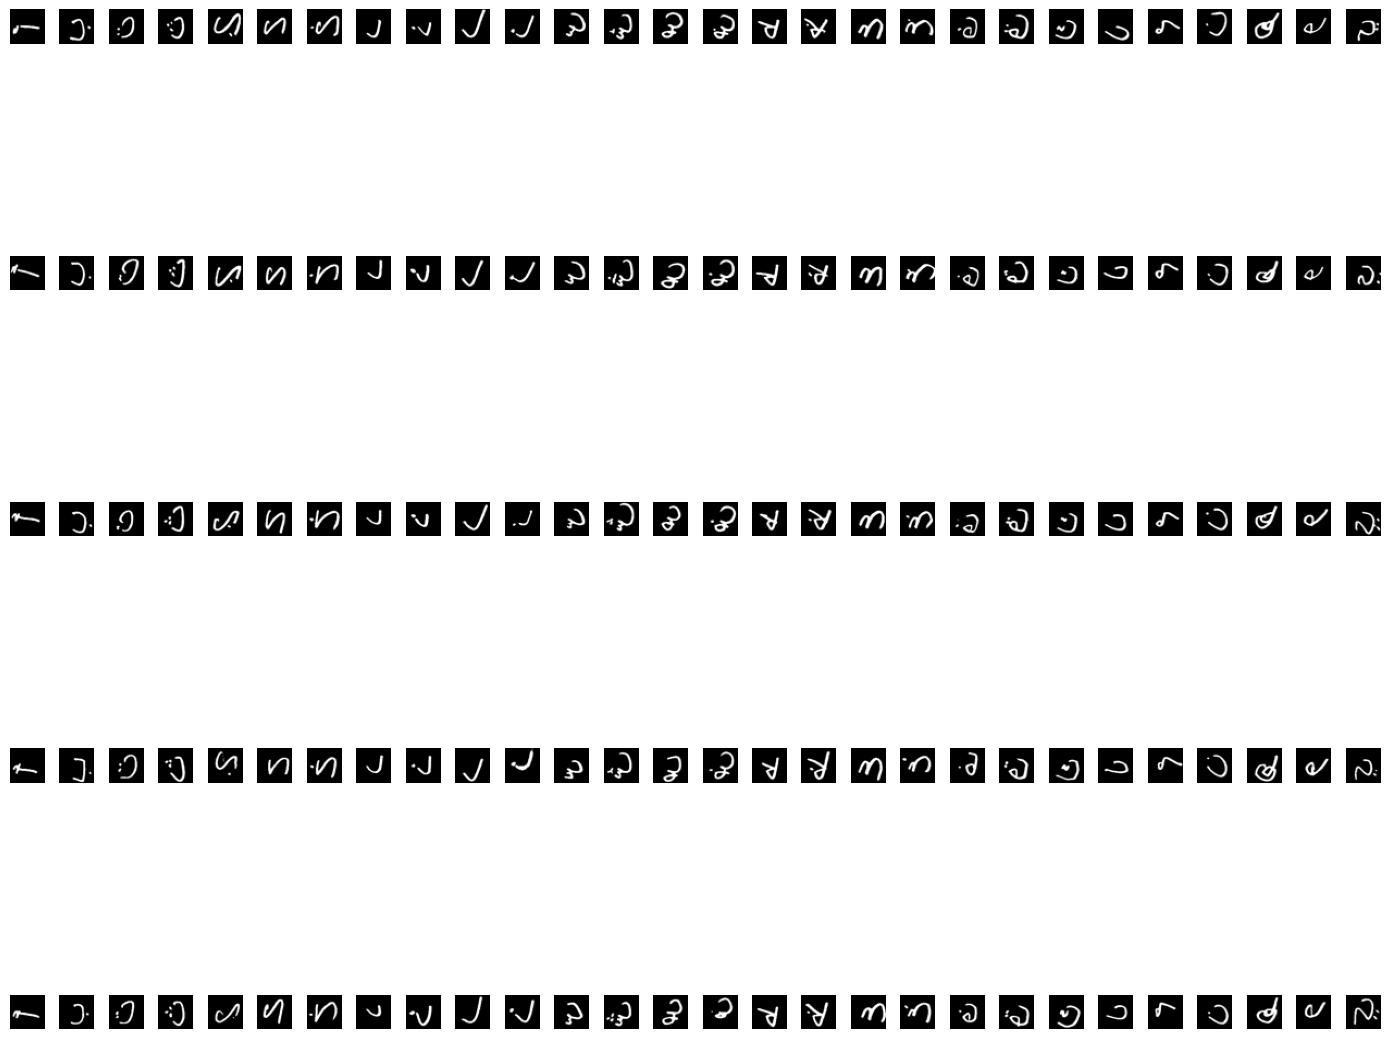

In [ ]:
# Plotting 10 examples of each digit
# Getting the list of unique classes
classes = np.unique(y_train)
classes


n_example_rows = 5
fig, axes = plt.subplots(ncols=28, nrows=n_example_rows, figsize=(14,14))
# axes = axes.flatten()x
for row in range(n_example_rows):
    row_axes = axes[row]
    for i, digit in enumerate(classes):
        # Get the axes
        ax = row_axes[i]
        # Filter for the current digit
        idx_digit = y_train == digit
        # Plot the first example digit
        ax.imshow(X_train[idx_digit][row], cmap="gray")
        ax.axis("off")
fig.tight_layout()



In [ ]:
X_train.shape

(13439, 32, 32)

In [ ]:
# Reshape data
X_train = X_train[..., tf.newaxis]
X_test = X_test[..., tf.newaxis]



In [ ]:
# Create One-Hot-Encoded target for Tensorflow
y_train = to_categorical(y_train-1,28)
y_test = to_categorical(y_test-1,28)
y_train[0]



array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
# Step 1: Define our network structure
# Save the input shape (skip the number of images)
input_shape = X_train.shape[1:]
input_shape



(32, 32, 1)

In [ ]:
# Write the building and compiling steps within a function
def build_model():
    # Instantatie model
    model = models.Sequential()
    # Scaling layer
    scaling_layer = layers.Rescaling(1./255, input_shape=input_shape)
    model.add(scaling_layer)

    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=8,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        ))
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=8,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        ))
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling

    # Flattening layer
    model.add(layers.Flatten())
    # Output layer
    model.add(
        layers.Dense(28, activation="softmax")  # How many output possibilities we have
    )  # What activation function are you using?

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()
    return model



In [ ]:
# Build the model
model1 = build_model()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 32, 32, 1)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 8)         80        
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 16, 16, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 8)         584       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 8, 8, 8)           0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 512)              

In [ ]:
# Make buffer size the same as the number of batches in train_ds
buffer_size = len(X_train)
buffer_size



13439

In [ ]:
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]



In [ ]:
# See how long it takes to fit the optimized dataset
# timing
import datetime as dt
start = dt.datetime.now()
# fit the neural network
epochs=25
history = model1.fit(
  X_train,
  y_train,
  validation_split=.2,
  epochs=epochs,
  callbacks=get_callbacks(),
)
end = dt.datetime.now()
dur2 = end-start
print(f"Training time: {dur2}")



Epoch 1/25
336/336 [==============================] - 5s 7ms/step - loss: 2.2647 - accuracy: 0.3357 - val_loss: 1.9473 - val_accuracy: 0.4390
Epoch 2/25
336/336 [==============================] - 2s 5ms/step - loss: 1.5057 - accuracy: 0.5504 - val_loss: 1.5538 - val_accuracy: 0.5365
Epoch 3/25
336/336 [==============================] - 1s 4ms/step - loss: 1.2228 - accuracy: 0.6229 - val_loss: 1.3273 - val_accuracy: 0.6097
Epoch 4/25
336/336 [==============================] - 1s 4ms/step - loss: 1.0641 - accuracy: 0.6661 - val_loss: 1.2480 - val_accuracy: 0.6157
Epoch 5/25
336/336 [==============================] - 1s 4ms/step - loss: 0.9538 - accuracy: 0.6998 - val_loss: 1.2296 - val_accuracy: 0.6391
Epoch 6/25
336/336 [==============================] - 1s 4ms/step - loss: 0.8681 - accuracy: 0.7297 - val_loss: 1.1533 - val_accuracy: 0.6611
Epoch 7/25
336/336 [==============================] - 1s 4ms/step - loss: 0.7966 - accuracy: 0.7449 - val_loss: 1.1022 - val_accuracy: 0.6674
Epoch 

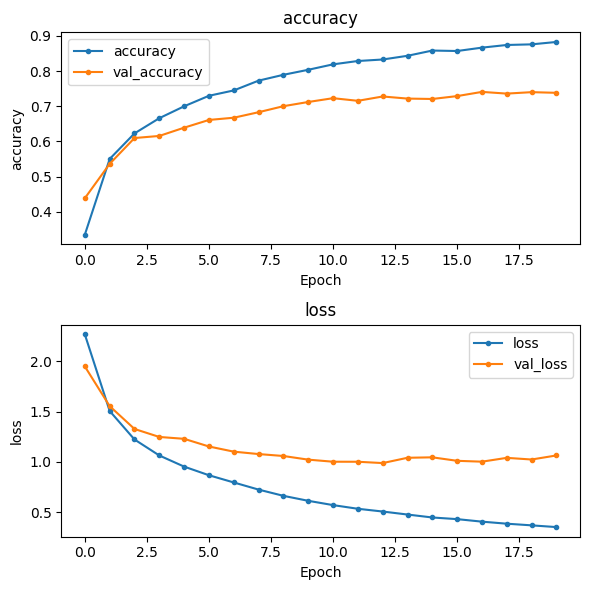


- Evaluating Network...
420/420 [==============================] - 1s 2ms/step
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       479
           1       0.91      0.94      0.93       480
           2       0.68      0.86      0.76       480
           3       0.88      0.69      0.77       480
           4       0.91      0.81      0.86       480
           5       0.84      0.79      0.81       480
           6       0.74      0.89      0.81       480
           7       0.84      0.89      0.87       480
           8       0.88      0.85      0.87       480
           9       0.90      0.89      0.89       480
          10       0.95      0.88      0.91       480
          11       0.80      0.88      0.84       480
          12       0.89      0.87   

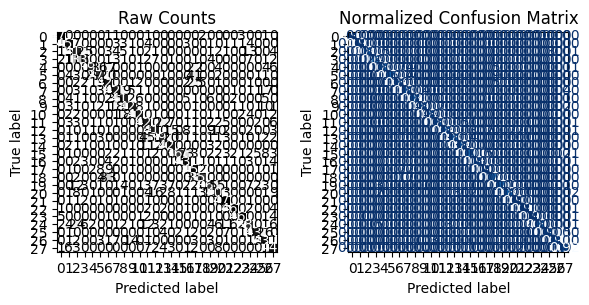


- Evaluating Training Data:
420/420 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
{'loss': 0.0, 'accuracy': 0.0}
105/105 [==============================] - 0s 2ms/step
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       119
           1       0.83      0.90      0.86       120
           2       0.60      0.72      0.65       120
           3       0.67      0.50      0.57       120
           4       0.89      0.64      0.74       120
           5       0.68      0.74      0.71       120
           6       0.67      0.85      0.75       120
           7       0.81      0.78      0.80       120
           8       0.79      0.80      0.80       120
           9       0.78      0.85      0.81       120
          10    

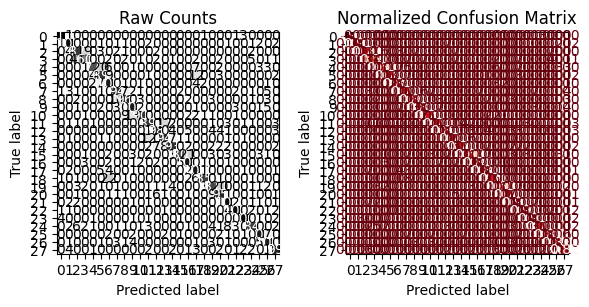


- Evaluating Test Data:
105/105 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
{'loss': 0.0, 'accuracy': 0.0}


In [ ]:
# Testing with the CNN + Dataset
evaluate_classification_network(model1,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test, history=history);



In [ ]:
!pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 4.5 MB/s eta 0:00:00


In [ ]:
from keras_tuner import HyperParameters as hp
import keras_tuner as kt

In [ ]:
def build_tune_model_deep(hp):
    model = models.Sequential()
    model.add(layers.Rescaling(1.0 / 255, input_shape=input_shape))
    # Setting hp params and saving as var so they can be used at >1 layer
    n_filters = hp.Int('filters_1',min_value=16, max_value=64, step=16)
    pool_strides = hp.Choice('pool_strides',[1,2])

    model.add(layers.Conv2D(n_filters,
                            # Test using larger kernel size (in first Conv layer ONLY)
                            kernel_size= hp.Choice('kernel_size_1',[3,5]),
                            padding='same')
             )
    model.add(layers.MaxPooling2D(2, strides=pool_strides))
    for i in range(hp.Int('n_conv_layers',min_value=1, max_value=3)):
        # Double the number of filters vs. previous layer
        n_filters = n_filters * 2
        model.add(layers.Conv2D(n_filters, kernel_size=3, padding='same'))
        model.add(layers.MaxPooling2D(2, strides=pool_strides))

        # model.add(layers.Dropout(hp.Float('dropout_rate',min_value=0.1, max_value=0.5, step=.1)))
    # Final layers
    model.add(layers.Flatten())
    model.add(layers.Dense(n_filters, activation="relu"))
    # Test various dropout strengths
    model.add(layers.Dropout(hp.Float('dropout_rate_dense',min_value=0, max_value=0.5,
                                     step=.1)))
    model.add(layers.Dense(28, activation="softmax"))
    model.compile(
        optimizer="adam",
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[
            "accuracy"],
    )
    return model



In [ ]:
# Define the tuner
tuner_hb = kt.Hyperband(build_tune_model_deep, objective='val_accuracy',
                        max_epochs=15, overwrite=True, seed=321,)
# Preivew search summary
tuner_hb.search_space_summary()



Search space summary
Default search space size: 5
filters_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
pool_strides (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2], 'ordered': True}
kernel_size_1 (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
n_conv_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
dropout_rate_dense (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}


In [ ]:
# Start search
tuner_hb.search(X_train,y_train, validation_split=.2, epochs=15,callbacks=get_callbacks())
# Obtain summary of results
tuner_hb.results_summary()



Trial 30 Complete [00h 00m 35s]
val_accuracy: 0.8508184552192688

Best val_accuracy So Far: 0.933779776096344
Total elapsed time: 00h 19m 13s
Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0016 summary
Hyperparameters:
filters_1: 64
pool_strides: 2
kernel_size_1: 5
n_conv_layers: 3
dropout_rate_dense: 0.30000000000000004
tuner/epochs: 15
tuner/initial_epoch: 5
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 0.933779776096344

Trial 0012 summary
Hyperparameters:
filters_1: 64
pool_strides: 2
kernel_size_1: 5
n_conv_layers: 3
dropout_rate_dense: 0.30000000000000004
tuner/epochs: 5
tuner/initial_epoch: 2
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0008
Score: 0.9196428656578064

Trial 0024 summary
Hyperparameters:
filters_1: 32
pool_strides: 2
kernel_size_1: 3
n_conv_layers: 3
dropout_rate_dense: 0.1
tuner/epochs: 15
tuner/initial_epoch: 5
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0020
Score

In [ ]:
# Print the results for beset paramters
print(f"Best Params: \n {tuner_hb.get_best_hyperparameters()[0].values}" )
# Define the best model
best_model = tuner_hb.get_best_models()[0]





Best Params: 
 {'filters_1': 64, 'pool_strides': 2, 'kernel_size_1': 5, 'n_conv_layers': 3, 'dropout_rate_dense': 0.30000000000000004, 'tuner/epochs': 15, 'tuner/initial_epoch': 5, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0012'}


In [ ]:
# See how long it takes to fit the optimized dataset
# timing
import datetime as dt
start = dt.datetime.now()
# fit the neural network
history = best_model.fit(
  X_train,
  y_train,
  validation_split=.2,
  epochs=10,
  callbacks=get_callbacks(),
)
end = dt.datetime.now()
dur2 = end-start
print(f"Training time: {dur2}")



Epoch 1/10
336/336 [==============================] - 10s 17ms/step - loss: 0.0040 - accuracy: 0.9882 - val_loss: 0.0346 - val_accuracy: 0.9178
Epoch 2/10
336/336 [==============================] - 8s 23ms/step - loss: 0.0058 - accuracy: 0.9861 - val_loss: 0.0360 - val_accuracy: 0.8862
Epoch 3/10
336/336 [==============================] - 4s 11ms/step - loss: 0.0098 - accuracy: 0.9729 - val_loss: 0.0479 - val_accuracy: 0.9029
Epoch 4/10
336/336 [==============================] - 3s 8ms/step - loss: 0.0074 - accuracy: 0.9802 - val_loss: 0.0377 - val_accuracy: 0.9312
Epoch 5/10
336/336 [==============================] - 3s 9ms/step - loss: 0.0058 - accuracy: 0.9853 - val_loss: 0.0324 - val_accuracy: 0.9252
Epoch 6/10
336/336 [==============================] - 3s 9ms/step - loss: 0.0073 - accuracy: 0.9822 - val_loss: 0.0354 - val_accuracy: 0.9182
Epoch 7/10
336/336 [==============================] - 3s 8ms/step - loss: 0.0050 - accuracy: 0.9890 - val_loss: 0.0439 - val_accuracy: 0.9129
Tr

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Input layer for single-channel (grayscale) images
input_layer = layers.Input(shape=input_shape)

# Repeat the single channel to create three channels
x = layers.Concatenate()([input_layer, input_layer, input_layer])

# Downloading just the convolutional base
vgg16_base = tf.keras.applications.VGG16(
    include_top=False, weights="imagenet", input_shape=(input_shape[0], input_shape[1], 3)
)

# Prevent layers from the base_model from changing
for layer in vgg16_base.layers:
    layer.trainable = False

# Create the preprocessing lambda layer
lambda_layer_vgg16 = tf.keras.layers.Lambda(
    lambda img: tf.image.grayscale_to_rgb(img), name="preprocess_input"
)

def build_vgg16_model():
    model = models.Sequential(name="VGG16")

    # Use input layer (lambda layer will handle rescaling)
    model.add(tf.keras.layers.Input(shape=input_shape))


    ## Adding preprocessing lamabda layer
    model.add(lambda_layer_vgg16)

    # Add pretrained base
    model.add(vgg16_base)

    # Flattening layer
    model.add(layers.Flatten())

    ## Adding a Hidden Dense Layer
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dropout(0.5))

    # Output layer
    model.add(layers.Dense(28, activation="softmax"))

    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    model.summary()
    return model


58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
model_vgg16 = build_vgg16_model()
model_vgg16.summary()



Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess_input (Lambda)   (None, 32, 32, 3)         0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 28)                7196      
                                                                 
Total params: 14853212 (56.66 MB)
Trainable params: 138524 (5

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess_input (Lambda)   (None, 32, 32, 3)         0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 28)                7196      
                                                                 
Total params: 14853212 (56.66 MB)
Trainable params: 138524 (5

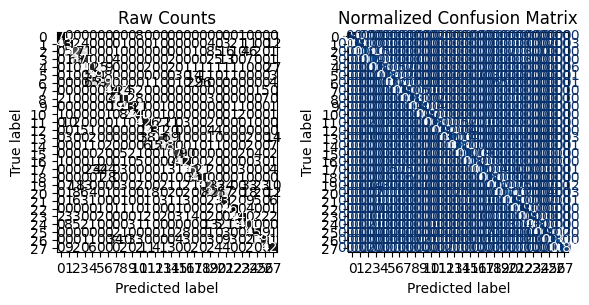


- Evaluating Training Data:
420/420 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
{'loss': 0.0, 'accuracy': 0.0}


In [ ]:
model_vgg16=build_vgg16_model()
history = model_vgg16.fit(X_train,y_train ,validation_split=.2,epochs=50,
                    callbacks=get_callbacks()
                         )

evaluate_classification_network(model_vgg16,X_train=X_train,y_train=y_train,history=history);


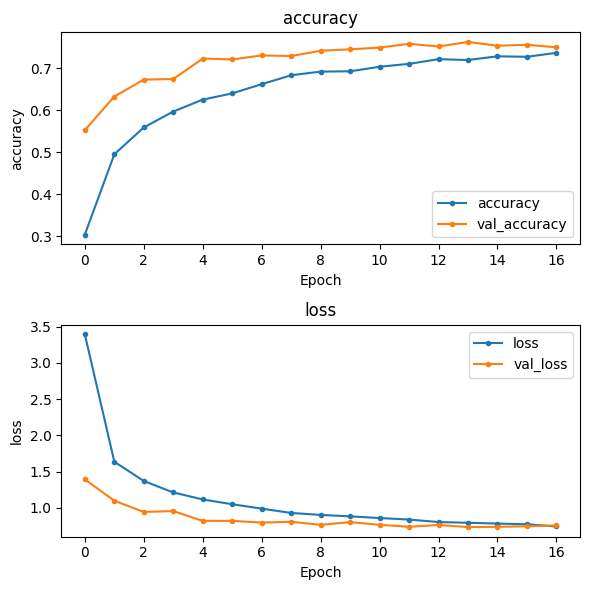


- Evaluating Network...
105/105 [==============================] - 1s 8ms/step
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       119
           1       0.89      0.87      0.88       120
           2       0.62      0.57      0.59       120
           3       0.75      0.74      0.75       120
           4       0.65      0.76      0.70       120
           5       0.73      0.82      0.77       120
           6       0.66      0.53      0.59       120
           7       0.85      0.82      0.84       120
           8       0.81      0.86      0.83       120
           9       0.85      0.93      0.89       120
          10       0.85      0.88      0.87       120
          11       0.84      0.81      0.82       120
          12       0.96      0.90      0

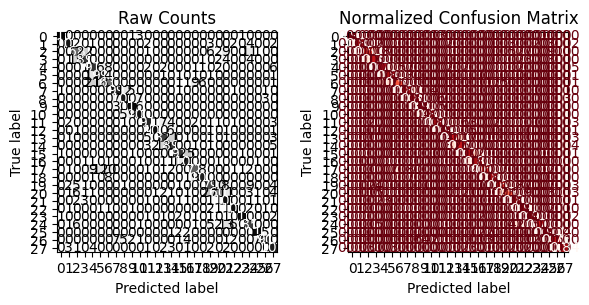


- Evaluating Test Data:
105/105 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
{'loss': 0.0, 'accuracy': 0.0}


In [ ]:
evaluate_classification_network(model_vgg16,X_test=X_test,y_test=y_test,history=history);


model_vgg16 is best model


In [ ]:
from tensorflow.keras.models import load_model, save_model

# Assuming you have a Keras model named 'model'
# Save the model to a file
save_model(best_model, '/content/drive/MyDrive/ CodingDojo/Intermediate ML/AR.h5')


<ipython-input-136-674adae1599e>:5: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(best_model, '/content/drive/MyDrive/ CodingDojo/Intermediate ML/AR.h5')


In [ ]:
arabic_alphabet = {
    1: 'أ',
    2: 'ب',
    3: 'ت',
    4: 'ث',
    5: 'ج',
    6: 'ح',
    7: 'خ',
    8: 'د',
    9: 'ذ',
    10: 'ر',
    11: 'ز',
    12: 'س',
    13: 'ش',
    14: 'ص',
    15: 'ض',
    16: 'ط',
    17: 'ظ',
    18: 'ع',
    19: 'غ',
    20: 'ف',
    21: 'ق',
    22: 'ك',
    23: 'ل',
    24: 'م',
    25: 'ن',
    26: 'ه',
    27: 'و',
    28: 'ي'
}


In [ ]:
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/ CodingDojo/Intermediate ML/AR.h5")
loaded_model.summary()
# Get predictions for sklearn metrics
y_test_pred = loaded_model.predict(X_test)
y_test_pred[0]




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 32, 32, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1664      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         2

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

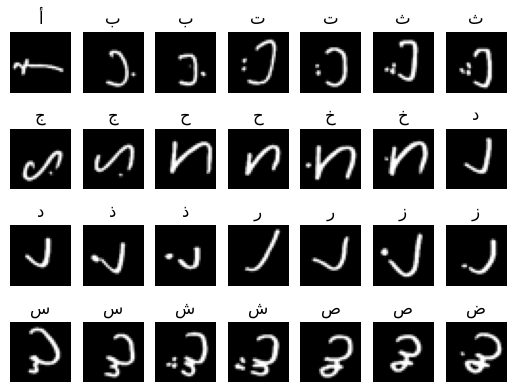

In [ ]:
value = []
for i in range(28):
  plt.subplot(4,7,i+1)
  plt.imshow(X_test[i].reshape(32,32),cmap='gray')
  value.append(y_test[i].argmax()+1)
  plt.title(arabic_alphabet[value[i]])
  plt.axis('off')

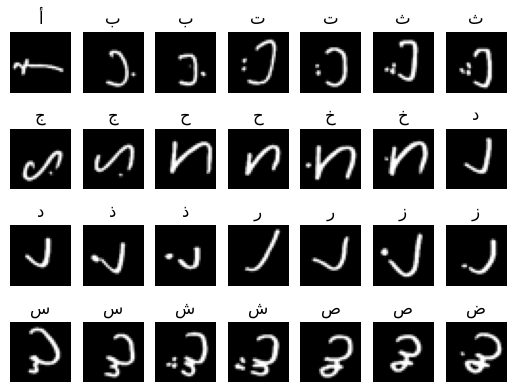

In [ ]:
value = []
for i in range(28):
  plt.subplot(4,7,i+1)
  plt.imshow(X_test[i].reshape(32,32),cmap='gray')
  value.append(y_test_pred[i].argmax()+1)
  plt.title(arabic_alphabet[value[i]])
  plt.axis('off')